In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
#####
# from numba import cuda
import pyculib
#####
import pycuda.gpuarray as gpuarray
from pycuda.cumath import tanh
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from pycuda.reduction import ReductionKernel
from pycuda.elementwise import ElementwiseKernel
#####
import skcuda.linalg as gpuLinalg
from skcuda.misc import sum as gpuSum
from skcuda.linalg import inv as invGPU
from skcuda.linalg import diag
from skcuda.misc import min as gpuMin
from skcuda.misc import max as gpuMax
gpuLinalg.init()
%matplotlib inline

In [2]:
def plot(data, name=None):
    hist = plt.hist(data, density=True)
    if name:
        plt.savefig('./plots/' + name + 'Hist.png', bbox_inches='tight')
    plt.show()
    
    plt.plot(data)
    if name:
        plt.savefig('./plots/' + name + 'Plot.png', bbox_inches='tight')
    plt.show()


In [3]:
sig = np.loadtxt(open('sig.csv'), delimiter=',')

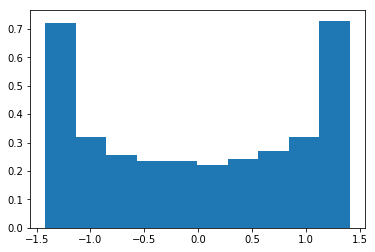

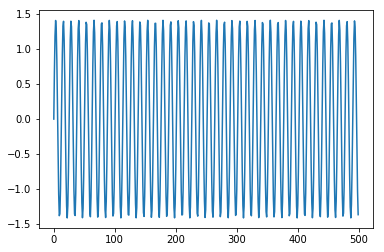

In [4]:
plot(sig[0])

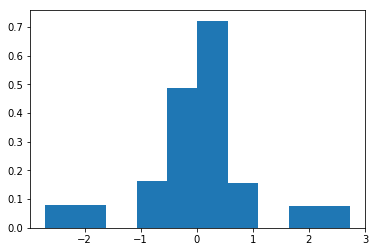

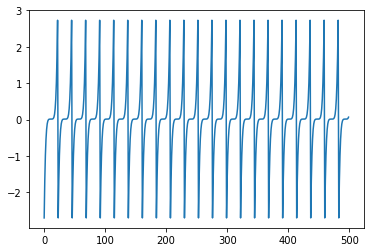

In [5]:
plot(sig[1])

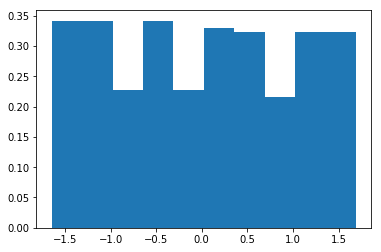

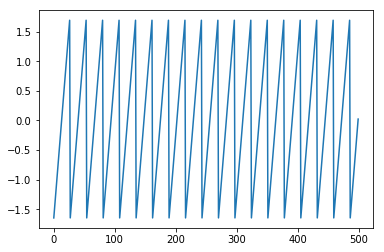

In [6]:
plot(sig[2])

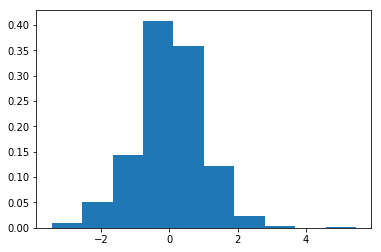

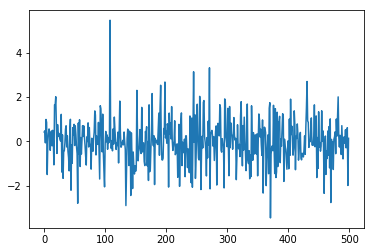

In [7]:
plot(sig[3])

In [8]:
mixedsig = np.loadtxt(open('mixedsig.csv'), delimiter=',')

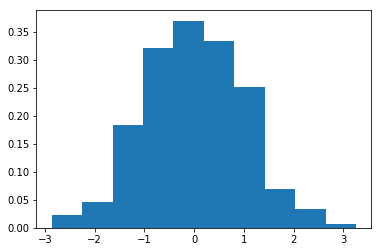

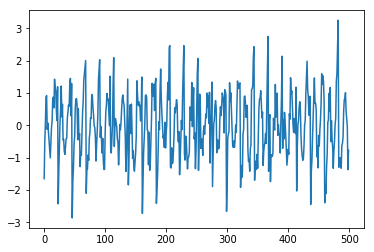

In [9]:
plot(mixedsig[0])

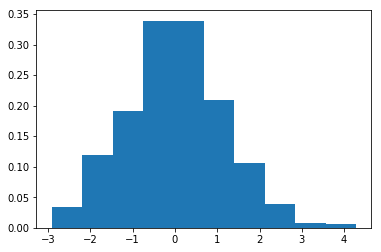

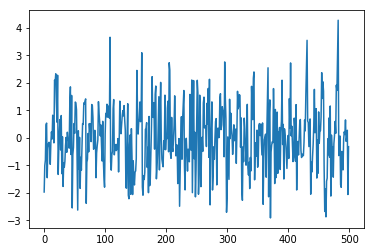

In [10]:
plot(mixedsig[1])

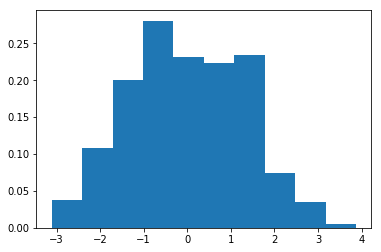

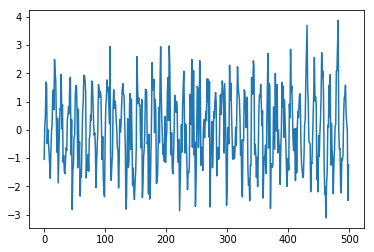

In [11]:
plot(mixedsig[2])

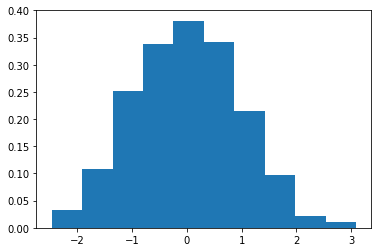

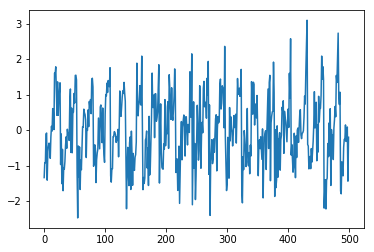

In [12]:
plot(mixedsig[3])

Functions

In [101]:
Tile = 8

mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void MatMulABT(float *A, float *B, float *C, int ARows, int ACols, int BRows, int BCols, int CRows, int CCols)
  {
    
    __shared__ float SA[TILE][TILE];
    __shared__ float SB[TILE][TILE];
    
    int ty = threadIdx.y;
    int tx = threadIdx.x;
    
    int Row = blockIdx.y*TILE + ty; //which block + TILE for index + threadId
    int Col = blockIdx.x*TILE + tx;
    
    float sum = 0;
    
    for (int i=0; i < (TILE + ACols - 1)/TILE; i++) {
        if (i*TILE + tx < ACols && Row < ARows)
            SA[ty][tx] = A[Row*ACols + i*TILE + tx];
        else
            SA[ty][tx] = 0.0;
          
        if (i*TILE + ty < BCols && Col < BRows)
            SB[ty][tx] = B[Col*BCols + i*TILE + ty];
        else
            SB[ty][tx] = 0.0;
        
        __syncthreads();
        
        for (int k=0; k < TILE; k++)
            sum += SA[ty][k]*SB[k][tx];
        
        __syncthreads();
    }
    
    int R = (blockIdx.y*blockDim.y + threadIdx.y)*CCols;
    int Co = blockIdx.x*blockDim.x + threadIdx.x;
    
    if (Row < CRows && Col < CCols)
        C[Co + R] = sum;
  }
  """ % {'TILE_SIZE': Tile})
MatMulABT = mod.get_function("MatMulABT")

mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void MatMulATB(float *A, float *B, float *C, int ARows, int ACols, int BRows, int BCols, int CRows, int CCols)
  {
    
    __shared__ float SA[TILE][TILE];
    __shared__ float SB[TILE][TILE];
    
    int ty = threadIdx.y;
    int tx = threadIdx.x;
    
    int Row = blockIdx.y*TILE + ty; //which block + TILE for index + threadId
    int Col = blockIdx.x*TILE + tx;
    
    float sum = 0;
    
    for (int i=0; i < (TILE + ARows - 1)/TILE; i++) {
        if (i*TILE + tx < ARows && Row < ACols)
            SA[ty][tx] = A[(i*TILE + tx)*ACols + Row];
        else
            SA[ty][tx] = 0.0;
          
        if (i*TILE + ty < BRows && Col < BCols)
            SB[ty][tx] = B[(i*TILE + ty)*BCols + Col];
        else
            SB[ty][tx] = 0.0;
        
        __syncthreads();
        
        for (int k=0; k < TILE; k++)
            sum += SA[ty][k]*SB[k][tx];
        
        __syncthreads();
    }
    
    int R = (blockIdx.y*blockDim.y + threadIdx.y)*CCols;
    int Co = blockIdx.x*blockDim.x + threadIdx.x;
    
    if (Row < CRows && Col < CCols)
        C[Co + R] = sum;
  }
  """ % {'TILE_SIZE': Tile})
MatMulATB = mod.get_function("MatMulATB")

mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void MatMul(float *A, float *B, float *C, int ARows, int ACols, int BRows, int BCols, int CRows, int CCols)
  {
    
    __shared__ float SA[TILE][TILE];
    __shared__ float SB[TILE][TILE];
    
    int ty = threadIdx.y;
    int tx = threadIdx.x;
    
    int Row = blockIdx.y*TILE + ty; //which block + TILE for index + threadId
    int Col = blockIdx.x*TILE + tx;
    
    float sum = 0;
    
    for (int i=0; i < (TILE + ACols - 1)/TILE; i++) {
        if (i*TILE + tx < ACols && Row < ARows)
            SA[ty][tx] = A[Row*ACols + i*TILE + tx];
        else
            SA[ty][tx] = 0.0;
          
        if (i*TILE + ty < BRows && Col < BCols)
            SB[ty][tx] = B[(i*TILE + ty)*BCols + Col];
        else
            SB[ty][tx] = 0.0;
        
        __syncthreads();
        
        for (int k=0; k < TILE; k++)
            sum += SA[ty][k]*SB[k][tx];
        
        __syncthreads();
    }
    
    int R = (blockIdx.y*blockDim.y + threadIdx.y)*CCols;
    int Co = blockIdx.x*blockDim.x + threadIdx.x;
    
    if (Row < CRows && Col < CCols)
        C[Co + R] = sum;
  }
  """ % {'TILE_SIZE': Tile})
MatMul = mod.get_function("MatMul")


mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void sumCol(float *x, float *y, int rows, int cols)
  {
    
    __shared__ float SA[TILE][TILE];
    
    int ty = threadIdx.y;
    int tx = threadIdx.x;
    
    int Row = blockIdx.y*blockDim.y + ty;
    int Col = blockIdx.x*blockDim.x + tx;
    
    if (Row < rows && Col < cols)
        SA[ty][tx] = y[Row*cols + Col];
    else
        SA[ty][tx] = 0.0;
    __syncthreads();
    
    if (Row < rows && Col < cols) {
        for (unsigned int i=1; i<blockDim.y; i*=2) {
            if (ty %% (2*i) == 0)
                SA[ty][tx] += SA[ty + i][tx];
        }
        
        if (ty == 0)
            x[Col + blockIdx.y*cols] = SA[0][tx];
    }
  }
  """ % {'TILE_SIZE': Tile})
sumCol = mod.get_function("sumCol")

Tile2 = 32

mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void Max(int *x, int *o_data, int n)
  {
    __shared__ int sdata[TILE];
    
    unsigned int tid = threadIdx.x;
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i < n)
        sdata[tid] = x[i];
    else
        sdata[tid] = 0.0;
    __syncthreads();
    
    for (unsigned int s=1; s < blockDim.x; s*=2) {
        if (tid %% (2*s) == 0)
            sdata[tid] = max(sdata[tid], sdata[tid + s] );
        __syncthreads();
    }
    
    if (tid == 0)
        o_data[blockIdx.x] = sdata[0];
  }
  """ % {'TILE_SIZE': Tile2})
gpuMaxc = mod.get_function("Max")

mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void Min(int *x, int *o_data, int n)
  {
    __shared__ int sdata[TILE];
    
    unsigned int tid = threadIdx.x;
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i < n)
        sdata[tid] = x[i];
    else
        sdata[tid] = 0.0;
    __syncthreads();
    
    for (unsigned int s=1; s < blockDim.x; s*=2) {
        if (tid %% (2*s) == 0)
            sdata[tid] = max(sdata[tid], sdata[tid + s] );
        __syncthreads();
    }
    
    if (tid == 0)
        o_data[blockIdx.x] = sdata[0];
  }
  """ % {'TILE_SIZE': Tile2})
gpuMinc = mod.get_function("Min")

mod = SourceModule("""
  
  __global__ void absSub(float *x, float *y, float *c, int n)
  {
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < n; i += blockDim.y * gridDim.y) {
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x) {
            x[j + n*i] = abs( abs(y[j + n*i]) - abs(c[j + n*i]) );
        }
    }
  }
  """)
absSub = mod.get_function("absSub")

mod = SourceModule("""
  
  __global__ void diag(float *x, float *y, int rows, int cols)
  {
    for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < rows; j += blockDim.x * gridDim.x) {
        if (j + j*cols < cols + rows*cols)
            x[j] = y[j + j*cols];
    }
  }
  """)
gpuDiag = mod.get_function("diag")

In [102]:
#My kernels

"""1 - hypTan*hypTan"""
#Only uses X dim
mod = SourceModule("""
  __global__ void elementWise(float *x, int n)
  {
    for (int i = threadIdx.x + blockIdx.x*blockDim.x; i < n; i += blockDim.x * gridDim.x)
        x[i] = 1 - x[i]*x[i];
  }
  """)
elementWise = mod.get_function("elementWise")

#IMPORTANT: SET TILE SIZE
"""ONES(DIM, DIM)*RowSum * C"""
mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void MatVecMulRow(float *x, float *y, int n)
  {
    __shared__ float Vec[TILE];
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < n; i += blockDim.y * gridDim.y) {
        Vec[threadIdx.y] = y[i];
        __syncthreads();
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x)
            x[j + n*i] = x[j + n*i]*Vec[threadIdx.y];
    }
  }
  """ % {'TILE_SIZE': Tile})

mod = SourceModule("""

  #define TILE %(TILE_SIZE)d
  
  __global__ void MatVecMul(float *x, float *y, int n)
  {
    
    //__shared__ float Vec[TILE];
    
    //int ty = threadIdx.y;
    //int tx = threadIdx.x;
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < n; i += blockDim.y * gridDim.y) {
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x) {
            //Vec[tx] = y[j]
            x[j + n*i] = x[j + n*i]*y[j];
        }
    }
  }
  """ % {'TILE_SIZE': Tile})
MatVecMul = mod.get_function("MatVecMul")

mod = SourceModule("""
  
  __global__ void Sub(float *x, float *y, float *c, int n)
  {
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < n; i += blockDim.y * gridDim.y) {
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x) {
            x[j + n*i] = y[j + n*i] - c[j + n*i];
        }
    }
  }
  """)
Sub = mod.get_function("Sub")

mod = SourceModule("""
  
  __global__ void Div(float *x, int y, int n)
  {
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < n; i += blockDim.y * gridDim.y) {
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x) {
            x[j + n*i] = x[j + n*i]/y;
        }
    }
  }
  """)
Div = mod.get_function("Div")

mod = SourceModule("""
  
  __global__ void Copy(float *x, float *y, int n)
  {
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < n; i += blockDim.y * gridDim.y) {
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x) {
            x[j + n*i] = y[j + n*i];
        }
    }
  }
  """)
Copy = mod.get_function("Copy")


mod = SourceModule("""
  
  __global__ void Mul(float *x, float *y, float z, int n)
  {
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < n; i += blockDim.y * gridDim.y) {
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x) {
            x[j + n*i] = y[j + n*i]*z;
        }
    }
  }
  """)
Mul = mod.get_function("Mul")

mod = SourceModule("""
  
  __global__ void GPUtanh(float *x, int cols, int rows)
  {
    
    for (int i = threadIdx.y + blockIdx.y*blockDim.y; i < rows; i += blockDim.y * gridDim.y) {
        for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < cols; j += blockDim.x * gridDim.x) {
            x[j + cols*i] = tanh(x[j + cols*i]);
        }
    }
  }
  """)
gpuTanh = mod.get_function("GPUtanh")

mod = SourceModule("""
  
  __global__ void CopyRow(float *x, float *y, int n)
  {
    
    for (int j = threadIdx.x + blockIdx.x*blockDim.x; j < n; j += blockDim.x * gridDim.x) {
        x[j] = y[j];
    }
  }
  """)
CopyRow = mod.get_function("CopyRow")

compareGpu = ReductionKernel(np.float32, neutral="0",
        reduce_expr="max(a, b)", map_expr="abs( abs(x[i]) - abs(y[i]) )",
        arguments="float *x, float *y")

def gpuMatMul(A, B, C, transa='n', transb='n', block=(32, 32, 1)):
    transa = transa.lower()
    transb = transb.lower()
    bx, by, bz = block
    Arow, Acol = A.shape
    Brow, Bcol = B.shape
    if bx > Tile:
        bx = Tile
    if by > Tile:
        by = Tile
    block = (bx, by, bz)
    try:
        if transa == 'n' and transb == 'n':
            if Acol != Brow:
                raise Exception('Not aligned, column in A: {} with row in B: {}'.format(Acol, Brow))
            MatMul(A, B, C, np.int32(A.shape[0]), np.int32(A.shape[1]),
                  np.int32(B.shape[0]), np.int32(B.shape[1]), np.int32(C.shape[0]), np.int32(C.shape[1]),
                  block=block, grid=(int(np.ceil(B.shape[1]/block[0])), int(np.ceil(A.shape[0]/block[1])), 1))
        elif transa == 't' and transb == 'n':
            if Arow != Brow:
                raise Exception('Not aligned, column in A: {} with row in B: {}'.format(Arow, Brow))
            MatMulATB(A, B, C, np.int32(A.shape[0]), np.int32(A.shape[1]),
                  np.int32(B.shape[0]), np.int32(B.shape[1]), np.int32(C.shape[0]), np.int32(C.shape[1]),
                  block=block, grid=(int(np.ceil(B.shape[1]/block[0])), int(np.ceil(A.shape[1]/block[1])), 1)) #grid
        elif transa == 'n' and transb == 't':
            if Acol != Bcol:
                raise Exception('Not aligned, column in A: {} with row in B: {}'.format(Acol, Bcol))
            MatMulABT(A, B, C, np.int32(A.shape[0]), np.int32(A.shape[1]),
                  np.int32(B.shape[0]), np.int32(B.shape[1]), np.int32(C.shape[0]), np.int32(C.shape[1]),
                  block=block, grid=(int(np.ceil(B.shape[0]/block[0])), int(np.ceil(A.shape[0]/block[1])), 1))
    except:
        print('A: ', A.shape)
        print('B: ', B.shape)
        print('C: ', C.shape)
        print(int(np.ceil(B.shape[1]/block[0])), int(np.ceil(A.shape[1]/block[1])), 1)
        raise Exception('ABCD')
        
def gpuSumCol(A, B, block, C):
    row, col = A.shape
    x, y, z = block
    bx = int(np.ceil(col/x))
    by = int(np.ceil(row/y))

    bRow, bCol = B.shape
    if bRow < by:
        by = bRow
#         print('Not enough rows in B. Fewer rows will be summed.')
    if bCol < bx:
        bx = bCol
        print('Not enough columns in B. Fewer columns will be summed.')
    grid = (bx, by, 1)
    
    sumCol(B, A, np.int32(row), np.int32(col), block=block, grid=grid )
    
    while by > 1:
        row = by
        by = int(np.ceil(by/y))
        grid = (bx, by, 1)
        
        sumCol(B, B, np.int32(row), np.int32(col), block=block, grid=grid )
    
    block = (x*y, 1, 1)
    bx = int(np.ceil(col/(x*y)))
    grid = (bx, 1, 1)
    
    CopyRow(C, B, np.int32(col), block=block, grid=grid)

#todo
def findMax(A, block):
    if len(A.shape) > 1:
        row, col = A.shape
    else:
        row = A.shape[0]
        col = 1
    x, y, z = block
    bx = int(np.ceil(col*row/x))

    grid = (bx, 1, 1)
    B = gpuarray.zeros(bx, np.float32)

    gpuMaxc(A, B, np.int32(row*col), block=block, grid=grid )

    while bx > 1:
        row = bx
        bx = int(np.ceil(bx/x))
        grid = (bx, 1, 1)
        
        gpuMaxc(B, B, np.int32(row), block=block, grid=grid )
    
    block = (1, 1, 1)
    grid = (1, 1, 1)
    
    C = gpuarray.zeros(1, np.float32)
    CopyRow(C, B, np.int32(1), block=block, grid=grid)
    
    return C

def findMin(A, block):
    if len(A.shape) > 1:
        row, col = A.shape
    else:
        row = A.shape[0]
        col = 1
    x, y, z = block
    bx = int(np.ceil(col*row/x))

    grid = (bx, 1, 1)
    B = gpuarray.zeros(bx, np.float32)

    gpuMinc(A, B, np.int32(row*col), block=block, grid=grid )

    while bx > 1:
        row = bx
        bx = int(np.ceil(bx/x))
        grid = (bx, 1, 1)
        
        gpuMinc(B, B, np.int32(row), block=block, grid=grid )
    
    block = (1, 1, 1)
    grid = (1, 1, 1)
    
    C = gpuarray.zeros(1, np.float32)
    CopyRow(C, B, np.int32(1), block=block, grid=grid)
    
    return C

def compareGpuC(A, B, block):
    row, col = A.shape
    C = gpuarray.zeros((row, col), np.float32)
    
    x, y, z = block
    bx = int(np.ceil(col/x))
    by = int(np.ceil(row/y))

    grid = (bx, by, 1)
    
    absSub(C, A, B, block=block, grid=grid)
    
    C = findMax(C, block)
    
    return C

def findDiag(A, diag, block=(32, 1, 1)):
    row, col = A.shape
    row = np.int32(row)
    col = np.int32(col)
    x, y, z = block
    
    bx = int(np.ceil(row/x))
    gpuDiag(diag, A, row, col, block=(32, 1, 1), grid=(bx, 1, 1))
    
    return diag

In [103]:
def PCA(data, firstEig=None, lastEig=None):
    if lastEig is None:
        lastEig = len(data) - 1
    if firstEig is None:
        firstEig = 0

    OldDim = len(data) #Amount of components

    COV = np.cov(data) # Dim x Dim
    D, E = np.linalg.eig(COV)

    rankTolerance = 1e-7
    maxLastEig = np.sum(D > rankTolerance)
    if maxLastEig == 0:
        raise Exception('Eigenvalues of the covariance matrix are all smaller than tolerance \
        Please make sure that your data matrix contains nonzero values. \
        \nIf the values are very small, try rescaling the data matrix.\n')

    maxLastEig = maxLastEig - 1 #for index
    eigenvalues = np.sort(D)[::-1]

    if lastEig > maxLastEig:
        lastEig = maxLastEig

    if lastEig < OldDim-1: #if lastEig essentially changes
        lowerLimitValue = (eigenvalues[lastEig] + eigenvalues[lastEig + 1]) / 2
    else:
        lowerLimitValue = eigenvalues[OldDim - 1] - 1 #It isn't inclusive

    lowerColumns = D > lowerLimitValue

    if firstEig > 0:
        higherLimitValue = (eigenvalues[firstEig - 1] + eigenvalues[firstEig]) / 2
    else:
        higherLimitValue = eigenvalues[0] + 1 #It isn't inclusive

    higherColumns = D < higherLimitValue

    selectedColumns = lowerColumns & higherColumns
    
    E = E[:, selectedColumns]
    D = np.diag(D[selectedColumns]) #Eigenvalues

    return E, D



Test run

In [104]:
"""This version of FastICA, copies B computes the square root of the matrix and copies it back to the GPU"""
def FastICASymmSwap(X, whitening, dewhitening, maxIterations, threshold):
    Dim, NumOfSampl = X.shape
    Dim = np.int32(Dim)
#     Dim = len(X)
#     NumOfSampl = len(X[0])

    B = linalg.orth(np.random.random((Dim, Dim))).astype(np.float32) #linalg.orth makes the array non contiguous
    #B.flags['C_CONTIGUOUS']
    
    print(B)
    B_gpu = gpuarray.to_gpu(np.ascontiguousarray(B, np.float32))
    #Bold
    Bold_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    Bold = np.zeros((Dim, Dim))
    #W
    A = np.zeros((Dim, Dim)) #maybe dtype
    #CTC
    CTC_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    #X
    X_gpu = gpuarray.to_gpu(X.astype(np.float32))
    #hypTan
    hypTan_gpu = gpuarray.zeros((NumOfSampl, Dim), np.float32)
    #rowSum
    rowSum_gpu = gpuarray.zeros(Dim, np.float32)
    #minAbsCos
    minAbsCos_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    
    #helpers
    sqrt = linalg.sqrtm  # sqrt on a matrix
    inv = np.linalg.inv
    eig = linalg.eig

    for i in range(0, maxIterations + 1):
        print(i, maxIterations)
        if i == maxIterations:
            print('Component {} did not converge after {} iterations'.format(i, maxIterations))
            B = B_gpu.get()
            if B.size != 0: #not empty

                B = B @ np.real(inv(sqrt(B.T @ B)))
                W = B.T @ whitening
                A = dewhitening @ B

                print('A:\n', A)
                print('W:\n', W)
                
                return A, W
        gpuLinalg.dot(B_gpu, B_gpu, transa='T', out=CTC_gpu) #WORKS! #B@B.T
        CTC = CTC_gpu.get()
        
        D, E = eig(CTC) #CHECK IF IMAGINARY

        D = np.sqrt(abs(D)) #We abs all the negative eigenvalues
        D_gpu = gpuarray.to_gpu(np.ascontiguousarray(np.diag(D)))
        E_gpu = gpuarray.to_gpu(np.ascontiguousarray(E))
        Einv_gpu =invGPU(E_gpu)
        
        gpuLinalg.dot(E_gpu, D_gpu, out=CTC_gpu) #WORKS!
        gpuLinalg.dot(CTC_gpu, Einv_gpu, out=CTC_gpu) #WORKS!
        
#Manual CPU
#         CTC = E@np.diag(D)@np.linalg.inv(E)
#         CTC_gpu.set(CTC.astype(np.float32))

#Direct
#         CTC = sqrt(CTC)
#         CTC_gpu.set(CTC)

        invGPU(CTC_gpu, overwrite=True)
        CTC_gpu = CTC_gpu.real
        
        gpuLinalg.dot(B_gpu, CTC_gpu, out=B_gpu) #WORKS! #B@(B@B.T)^-1
        
        gpuLinalg.dot(B_gpu, Bold_gpu, transa='T', out=minAbsCos_gpu) #This sometimes gives different values then C.T @ Bold
        minAbsCos2 = gpuMin(abs(gpuMin(minAbsCos_gpu))).get()
        
#         minAbsCos = min(abs(np.diag(C.T @ Bold)))
        minAbsCos = minAbsCos2[0, 0]
#         print(minAbsCos2)
#         print(1-minAbsCos < threshold)
#         print('IS IT THE SAME:', np.allclose(minAbsCos_gpu.get(), C.T@Bold))
#         print('IS IT THE SAME:', 1 - minAbsCos2[0, 0] < threshold)
        if 1 - minAbsCos < threshold:
            print('here')
            
            C = B_gpu.get()
        
            A = dewhitening @ C
            W = C.T @ whitening
            
            print('A:\n', A)
            print('W:\n', W)
            return A, W
        
        ######################### READ ABOUT DYNAMIC PARALLELISM AND UNIFIED MEMORY
        Copy(Bold_gpu, B_gpu, Dim, block=(4, 4, 1), grid=(1, 1, 1)) #Bold = B
        
        gpuLinalg.dot(X_gpu, B_gpu, transa='T', out=hypTan_gpu) #WORKS! #X.T@B
        tanh(hypTan_gpu, out=hypTan_gpu) #WORKS! #Elementwise
        gpuLinalg.dot(X_gpu, hypTan_gpu, out=CTC_gpu) #WORKS! #X@hypTan

        n = Dim*NumOfSampl
        elementWise(hypTan_gpu, np.int32(n), block=(128, 1, 1), grid=(1,1,1)) #1 - hypTan*hypTan
        
        gpuSum(hypTan_gpu, axis=0, out=rowSum_gpu)
        MatVecMul(B_gpu, rowSum_gpu, Dim, block=(4, 4, 1), grid=(1,1,1))
        
        Sub(B_gpu, CTC_gpu, B_gpu, Dim, block=(4, 4, 1), grid=(1,1,1)) #C = left - right
        Div(B_gpu, np.int32(NumOfSampl), Dim, block=(4, 4, 1), grid=(1,1,1)) #Division by scalar

In [108]:
"""This version of FastICA, uses approximation for B"""
def FastICASymmApro(X, whitening, dewhitening, maxIterations, threshold):
    Threads = 8
    ThreadBlock = (Threads, Threads, 1)
    
    Dim, NumOfSampl = X.shape
    Dim = np.int32(Dim)
    B = linalg.orth(np.random.random((Dim, Dim))).astype(np.float32) #linalg.orth makes the array non contiguous
    #B.flags['C_CONTIGUOUS']
    
    print(B)
    B_gpu = gpuarray.to_gpu(np.ascontiguousarray(B, np.float32))
    #Bold
    Bold_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    Bold = np.zeros((Dim, Dim))
    #W
    A = np.zeros((Dim, Dim)) #maybe dtype
    #CTC
    CTC_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    #X
    X_gpu = gpuarray.to_gpu(X.astype(np.float32))
    #hypTan
    hypTan_gpu = gpuarray.zeros((NumOfSampl, Dim), np.float32)
    #rowSum
    row = int(np.ceil(NumOfSampl/32))
    Sum_gpu = gpuarray.zeros((row, Dim), np.float32)
    rowSum_gpu = gpuarray.zeros(Dim, np.float32)
    #minAbsCos
    minAbsCos_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    #left, right
    left_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    right_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    #Identity
    I_gpu = gpuarray.to_gpu(np.eye(Dim).astype(np.float32))
    Check_gpu = gpuarray.zeros((Dim, Dim), np.float32)
    #diag
    diag_gpu = gpuarray.zeros(Dim, np.float32)
    
    for i in range(0, maxIterations + 1):
        print(i, maxIterations)
        if i == maxIterations:
            print('Component {} did not converge after {} iterations'.format(i, maxIterations))
            B = B_gpu.get()
            if B.size != 0: #not empty

                B = B @ np.real(inv(sqrt(B.T @ B)))
                W = B.T @ whitening
                A = dewhitening @ B

                print('A:\n', A)
                print('W:\n', W)
                
                return A, W
        
        
        f = True
        j = 0
        
        gpuMatMul(B_gpu, B_gpu, CTC_gpu, transb='T', block=ThreadBlock)
        gpuSumCol(CTC_gpu, Sum_gpu, (Threads, Threads, 1), rowSum_gpu)
        norm = findMax(rowSum_gpu, (31, 1, 1))
    
        Div(B_gpu, norm, Dim, block=ThreadBlock, grid=(1,1,1)) #Division by scalar
        #maybe check every 5 iterations
        while f:
            Mul(left_gpu, B_gpu, np.float32(3/2), Dim, block=ThreadBlock, grid=(1,1,1)) #Division by scalar
            
            gpuMatMul(B_gpu, B_gpu, right_gpu, transb='T', block=ThreadBlock)
            gpuMatMul(right_gpu, B_gpu, right_gpu, block=ThreadBlock)
            Mul(right_gpu, right_gpu, np.float32(1/2), Dim, block=ThreadBlock, grid=(1,1,1)) #Division by scalar
            
            Sub(B_gpu, left_gpu, right_gpu, Dim, block=ThreadBlock, grid=(1,1,1)) #C = left - right
            gpuMatMul(B_gpu, B_gpu, Check_gpu, transb='T', block=ThreadBlock)
            
#             if j >= 10:
            f = compareGpuC(Check_gpu, I_gpu, ThreadBlock).get()
            f = not f <= threshold
            j += 1
#             j+=1

        gpuMatMul(B_gpu, Bold_gpu, minAbsCos_gpu, transa='T', block=ThreadBlock)

        minAbsCos2 = findMin(abs(findDiag(minAbsCos_gpu, diag_gpu)), (31, 1, 1)).get()

        minAbsCos = minAbsCos2[0]
    
        if 1 - minAbsCos < threshold:
            print('here')
            
            C = B_gpu.get()
        
            A = dewhitening @ C
            W = C.T @ whitening
            
            print('A:\n', A)
            print('W:\n', W)
            return A, W
        
        Copy(Bold_gpu, B_gpu, Dim, block=ThreadBlock, grid=(1, 1, 1)) #Bold = B
        
        gpuMatMul(X_gpu, B_gpu, hypTan_gpu, transa='T', block=ThreadBlock)
        gpuTanh(hypTan_gpu, np.int32(hypTan_gpu.shape[1]), np.int32(hypTan_gpu.shape[0]),
                block=ThreadBlock, grid=(1, 1, 1))
        gpuMatMul(X_gpu, hypTan_gpu, CTC_gpu, block=ThreadBlock)
        
        n = Dim*NumOfSampl
        elementWise(hypTan_gpu, np.int32(n), block=(Threads*Threads, 1, 1), grid=(1,1,1)) #1 - hypTan*hypTan
        
        gpuSumCol(hypTan_gpu, Sum_gpu, ThreadBlock, rowSum_gpu)
        MatVecMul(B_gpu, rowSum_gpu, Dim, block=ThreadBlock, grid=(1,1,1))
        
        Sub(B_gpu, CTC_gpu, B_gpu, Dim, block=ThreadBlock, grid=(1,1,1)) #C = left - right
        Div(B_gpu, np.int32(NumOfSampl), Dim, block=ThreadBlock, grid=(1,1,1)) #Division by scalar

In [109]:

#Using g(y) = tanh(y)
def FastICA(mixedsig, approach='Swap', maxIterations=10, threshold=0.0001):
    Dim = len(mixedsig)

    #Center X
    m = np.mean(mixedsig, 1)
    m = m.reshape((Dim, 1))

    mixedmean = mixedsig.copy() - m

    #PCA and whitening
    #E - the eigenvectors, an orthogonal matrix, Dim x Dim-k
    #D - the eigenvalues
    E, D = PCA(mixedsig) #maybe check if D contains negative values
    #todo read theory about mixedmin

    WhiteningMatrix = np.linalg.inv(np.sqrt(D)) @ E.T
    DewhiteningMatrix = E @ np.sqrt(D)

    Whitesig = WhiteningMatrix @ mixedsig
    print(mixedsig.shape)
    print(Whitesig.shape)
    if not np.all(np.isreal(Whitesig)):
        raise Exception('Whitened matrix has imaginary values!') #should this be a warning

    #A - mixing matrix
    #W - demixing matrix
    if approach == 'Swap':
        A, W = FastICASymmSwap(Whitesig, WhiteningMatrix, DewhiteningMatrix, maxIterations, threshold)
    if approach == 'Apro':
        A, W = FastICASymmApro(Whitesig, WhiteningMatrix, DewhiteningMatrix, maxIterations, threshold)

    return W@(mixedmean + m), A, W

In [110]:
I, A, W = FastICA(mixedsig[:, :], 'Apro', 2000, 0.000001)

(11, 1353079)
(9, 1353079)
[[-0.26217824 -0.45283446 -0.3642872  -0.01756586  0.55740255  0.37860969
   0.07988629  0.12619196 -0.34181967]
 [-0.43040904  0.41670874  0.28950354  0.42522082 -0.10716682  0.27639163
  -0.02483313 -0.19663656 -0.49931669]
 [-0.32403749  0.10279763  0.2315218  -0.35698199 -0.2448182   0.32138696
   0.19872685  0.69298536  0.14299409]
 [-0.31288353 -0.40611896 -0.26721853  0.35202849 -0.49759799 -0.45385757
   0.12578678  0.21624133 -0.16021366]
 [-0.39213747 -0.20782779  0.52837235 -0.00159189  0.39693478 -0.41199073
  -0.41048637  0.08997741  0.14130592]
 [-0.36506501  0.02296221 -0.3958019  -0.08452242 -0.25477567  0.28383207
  -0.62529677 -0.20086385  0.35437757]
 [-0.27069733 -0.34782532  0.25664067  0.02097242 -0.08433945  0.20718749
   0.50780559 -0.50749356  0.4171094 ]
 [-0.2247389   0.0355867  -0.04225257 -0.74613792 -0.13975674 -0.26937327
   0.06015893 -0.33420441 -0.42698166]
 [-0.36371052  0.52898616 -0.39368546  0.05665932  0.34808767 -0.3243

KeyboardInterrupt: 

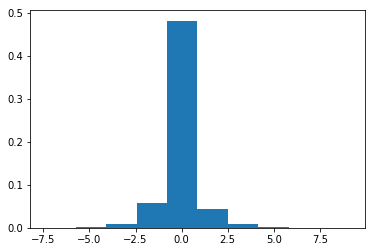

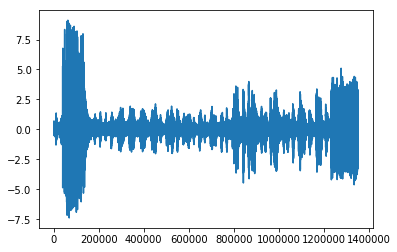

In [97]:
plot(I[0])

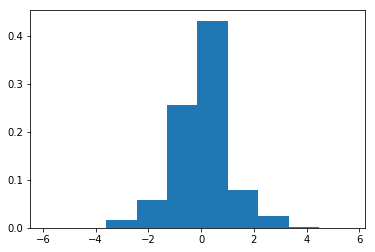

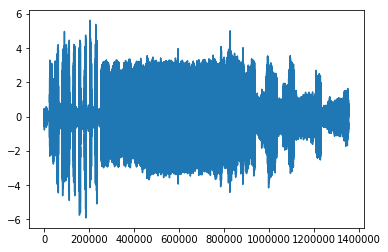

In [98]:
plot(I[1])

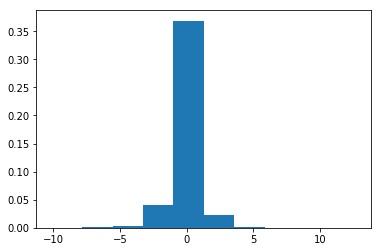

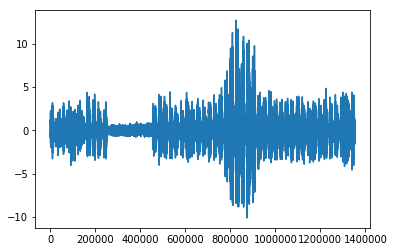

In [99]:
plot(I[2])

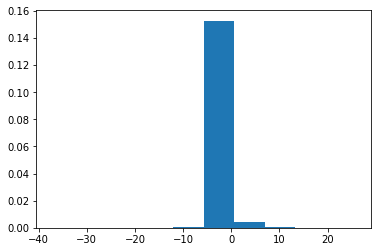

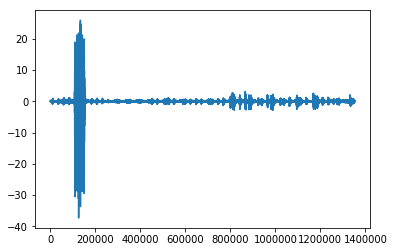

In [100]:
plot(I[3])

In [31]:
from scipy.io.wavfile import read, write
import numpy as np

rate, data = read('signals30.wav')
data = data.T.copy()
# data = data.astype(np.float32)

In [34]:
mixedsig = A@data[:,:]

In [28]:
mixedsig.shape

(11, 1353079)

In [33]:
A = np.random.rand(11, 11)

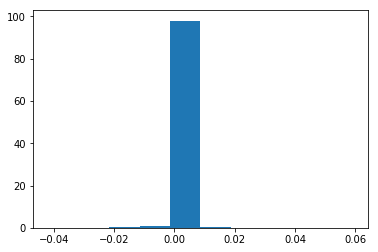

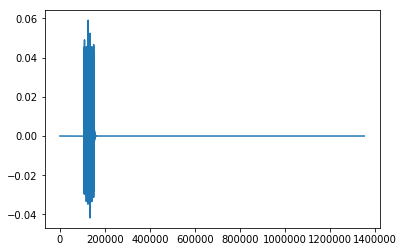

In [30]:
plot(data[1, :])

In [31]:
plot(I[10]*-1)

IndexError: index 10 is out of bounds for axis 0 with size 4

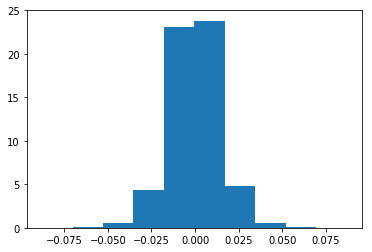

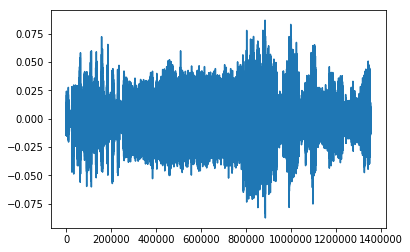

In [32]:
plot(mixedsig[4])

In [68]:
write('test_cuda.wav', rate, I.T)

In [12]:
np.save('A', A)